In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import librosa, librosa.display
from IPython import display
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
display.set_matplotlib_formats('svg')

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/73/b0btw3bd7rn_53l7vz7cn0w40000gn/T/ipykernel_53135/1423625376.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
#Visualize data for beat classification
df = pd.read_csv("dataset/set_b.csv")
df.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [3]:
len(df['fname'])

656

<AxesSubplot:>

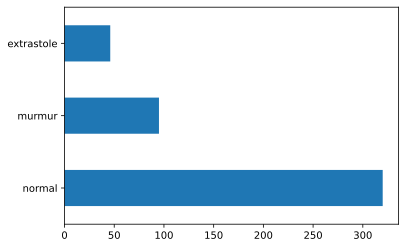

In [4]:
#Visualizing labels
y = df["label"]
y.value_counts().plot(kind="barh")

murmur = 3x less than normal, extrastole = 6x
Upsampling for extrastole + murmur may be needed

<AxesSubplot:>

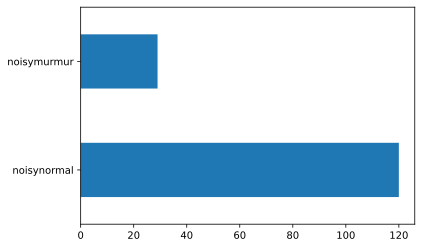

In [5]:
#Visualizing sublabel
sublabel = df["sublabel"]
sublabel.value_counts().plot(kind="barh")

Visualize soundwaves in its raw form

In [6]:
#Visualize normal vs murmur vs extrastole
normal_sample = "dataset/set_b/normal_103_1305031931979_B.wav"
murmur_sample = "dataset/set_b/murmur_112_1306243000964_A.wav"
extrast_sample = "dataset/set_b/extrastole_274_1311075637574_A.wav"

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,8))
normal_sn, normal_sr = librosa.load(normal_sample, sr=22050)
normal_soundwave = librosa.display.waveshow(normal_sn, sr=normal_sr, ax=ax[0])
ax[0].set_title("Normal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")
ax[0].label_outer()

murmur_sn, murmur_sr = librosa.load(murmur_sample, sr=22050)
murmur_soundwave = librosa.display.waveshow(murmur_sn, sr=murmur_sr, ax=ax[1])
ax[1].set_title("Murmur")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")
ax[1].label_outer()

extrast_sn, extrast_sr = librosa.load(extrast_sample, sr=22050)
extrast_soundwave = librosa.display.waveshow(extrast_sn, sr=extrast_sr, ax=ax[2])
ax[2].set_title("Extrastole")
ax[2].set_xlabel("Time (seconds)")
ax[2].set_ylabel("Amplitude")
ax[2].label_outer()

In [7]:
#Visualzing sounds
import IPython.display as ipd
ipd.Audio(normal_sn, rate=normal_sr)

In [8]:
df.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

"dataset" aned "sublabel" seems to be irrelevant as we're doing a classification with "label" as our y_train. Therefore we eliminate "sublabel" and "dataset"

In [9]:
#Data preprocessing
df = df.drop(["dataset", "sublabel"], axis=1)
df.dropna(inplace=True)

In [10]:
#Confirm that all labels are present
df.isnull().sum()


fname    0
label    0
dtype: int64

<h2>Replacing text with numerical values to prepare for one-hot encoding</h2>

In [11]:
#Replace labels with numbers
df['label'] = df['label'].map({'normal': 0, 'murmur': 1, 'extrastole': 2})

<h3>The filenames are not the same as the actual audio filenames. Therefore we edit each label to access the "dataset/" dir first. Then delete "Btraining_" as it is not present in the audio </h3>

In [12]:
#Reset index
df = df.reset_index()
df = df.drop(["index"], axis=1)
df.head()

fname  label
0  set_b/Btraining_extrastole_127_1306764300147_C...      2
1  set_b/Btraining_extrastole_128_1306344005749_A...      2
2  set_b/Btraining_extrastole_130_1306347376079_D...      2
3  set_b/Btraining_extrastole_134_1306428161797_C...      2
4  set_b/Btraining_extrastole_138_1306762146980_B...      2

In [13]:
#Delete "Btraining_", add "dataset", and add double "__"
for index, fname in tqdm(enumerate(df['fname'])):
    if fname.startswith("Bunlabelledtest"):
        df.drop(index, inplace=True)
    else:
        df['fname'][index] = "dataset/" + fname.replace("Btraining_", "")

0it [00:00, ?it/s]/var/folders/73/b0btw3bd7rn_53l7vz7cn0w40000gn/T/ipykernel_53135/927578912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fname'][index] = "dataset/" + fname.replace("Btraining_", "")
461it [00:03, 132.00it/s]


In [14]:
df.head()

fname  label
0  dataset/set_b/extrastole_127_1306764300147_C2.wav      2
1   dataset/set_b/extrastole_128_1306344005749_A.wav      2
2   dataset/set_b/extrastole_130_1306347376079_D.wav      2
3  dataset/set_b/extrastole_134_1306428161797_C1.wav      2
4   dataset/set_b/extrastole_138_1306762146980_B.wav      2

In [15]:
#In set_b, there are double underscores in the fname. Therefore, we replace them to 1 underscore
import os
os.chdir("dataset/set_b/")


In [16]:
#Rename the files
fnames = os.listdir()
for fname in fnames:
    if "__" in fname:
        os.rename(fname, fname.replace("__", "_"))

In [17]:
df.label.value_counts()

0    320
1     95
2     46
Name: label, dtype: int64

<h3>Prepare Data for Upsampling</h3>
Upscale murmur and extrastole to the amount of normal samples

In [18]:
#Select Samples
df_normal = df.loc[df['label'] == 0]
df_murmur = df.loc[df['label'] == 1]
df_extrastole = df.loc[df['label'] == 2]

In [19]:
#Upsampling data to df_normal.shape[0]
from sklearn.utils import resample
x_murmur_upsampled = resample(df_murmur, n_samples=df_normal.shape[0], random_state=123)
x_extrastole_upsampled = resample(df_extrastole, n_samples=df_normal.shape[0], random_state=123)

In [20]:
df_final = pd.concat([df_normal, x_murmur_upsampled, x_extrastole_upsampled])

In [21]:
df_final = df_final.reset_index()
df_final = df_final.drop(["index"], axis=1)
df_final.head()

fname  label
0   dataset/set_b/normal_103_1305031931979_B.wav      0
1  dataset/set_b/normal_103_1305031931979_D1.wav      0
2  dataset/set_b/normal_103_1305031931979_D2.wav      0
3  dataset/set_b/normal_103_1305031931979_D3.wav      0
4  dataset/set_b/normal_106_1306776721273_B1.wav      0

<AxesSubplot:>

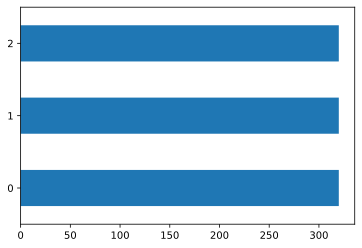

In [22]:
#Visualize distribution of labels (Check if sample size are the same)
df_final.label.value_counts().plot(kind="barh")

In [23]:
#Go back to root directory
os.chdir("..")
os.chdir("..")

<h3>Time frequency / Spectogram / MFCC visualization of audio</h3>

In [24]:
sample_signal, sr = librosa.load(df_final['fname'][0], sr=22050)

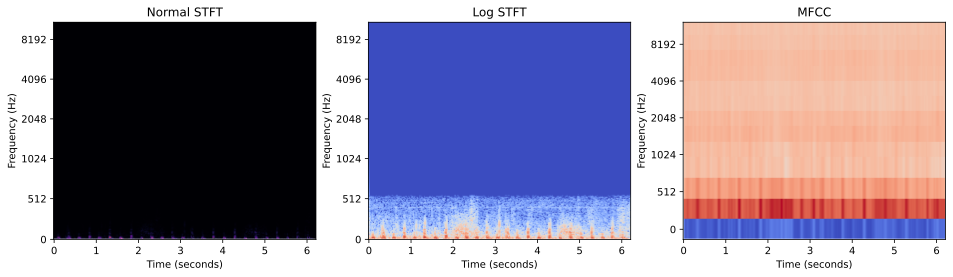

In [25]:
#Visualize stft

n_fft = 2048
hop_length = 512

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
stft = librosa.core.stft(sample_signal, n_fft=n_fft, hop_length=hop_length)
spectogram = np.abs(stft)
librosa.display.specshow(spectogram, sr=22050, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set_title("Normal STFT")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].label_outer()


log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram, sr=22050, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1], n_fft=n_fft,)
ax[1].set_title("Log STFT")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Frequency (Hz)")
ax[0].label_outer()

mfcc = librosa.feature.mfcc(y=np.array(sample_signal), sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
librosa.display.specshow(mfcc, sr=22050, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set_title("MFCC")
ax[2].set_xlabel("Time (seconds)")
ax[2].set_ylabel("Frequency (Hz)")
ax[0].label_outer()



In [26]:
list1 = np.array([1,2,3])
list2 = np.array([4,5,6])

list1 * list2


array([ 4, 10, 18])

<h3>Audio Preprocessing</h3>
<h4>The audio is ranged from 1 - 30 seconds. Therefore, we'll limit the audio at 15 seconds. For those which has a duration less than 10 seconds, we'll pad the audio to fill 15 seconds</h4>

In [28]:
#A function for loading and resampling audio
def load_audio(duraiton=15):
    data = []
    for filename in tqdm(df_final['fname']):
        signal, sr = librosa.load(filename, sr=22050)
        time = librosa.get_duration(y=signal, sr=sr)
        if round(time) < 10:
            audio = librosa.util.fix_length(signal, size=sr * duraiton, mode='wrap')
            mfccs = librosa.feature.mfcc(y=audio, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        data.append(mfccs)
    return data


In [29]:
hello = np.array([1,2,3,4,5])
new_hello = librosa.util.fix_length(hello, size=10, mode='wrap')
new_hello

array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5])

In [30]:
#One hot encoding
x = load_audio(15)
y = to_categorical(df_final['label'], num_classes=3)

100%|██████████| 960/960 [01:20<00:00, 11.89it/s]


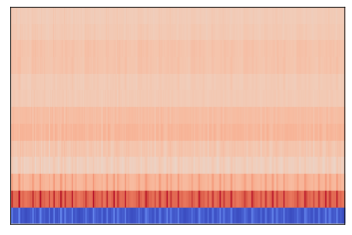

In [31]:
x = np.array(x)
y = np.array(y)
librosa.display.specshow(x[6])

In [82]:
#Split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [83]:
x_train.shape

(768, 13, 646)

In [84]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [86]:
x_train[0].shape

(13, 646, 1)

In [95]:
#Create a model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

#create a model which classifies a spectogram into one of the three classes
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(13, 646, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
model.summary()

Epoch 1/50


2022-08-27 20:18:00.905842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 50ms/step - loss: 1.6971 - accuracy: 0.5326 - val_loss: 23.0452 - val_accuracy: 0.2922
Epoch 2/50
 1/20 [>.............................] - ETA: 0s - loss: 0.8579 - accuracy: 0.6562

2022-08-27 20:18:01.993334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 39ms/step - loss: 0.5618 - accuracy: 0.7687 - val_loss: 2.5181 - val_accuracy: 0.6364
Epoch 3/50
20/20 [==============================] - 1s 37ms/step - loss: 0.2914 - accuracy: 0.9121 - val_loss: 1.0526 - val_accuracy: 0.6818
Epoch 4/50
20/20 [==============================] - 1s 37ms/step - loss: 0.1449 - accuracy: 0.9674 - val_loss: 0.6257 - val_accuracy: 0.7532
Epoch 5/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0958 - accuracy: 0.9723 - val_loss: 0.5889 - val_accuracy: 0.7727
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0674 - accuracy: 0.9853 - val_loss: 0.7125 - val_accuracy: 0.7273
Epoch 7/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0527 - accuracy: 0.9919 - val_loss: 0.5508 - val_accuracy: 0.7987
Epoch 8/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0583 - accuracy: 0.9870 - val_loss: 0.3366 - val_accuracy: 0.8766
Epoch 9/50
20/20 [======

In [102]:
prd = model.predict(x_test)

2

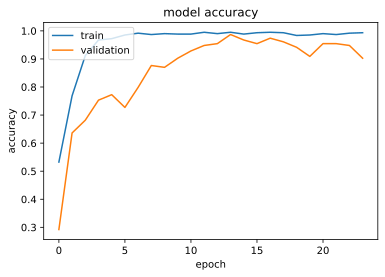

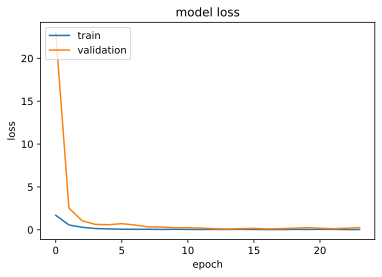

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [111]:
#Visualize confusion matrix
from sklearn.metrics import confusion_matrix
y_prd = prd.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [112]:
confusion_matrix(y_test, y_prd)

array([[56,  8,  9],
       [ 0, 57,  0],
       [ 0,  0, 62]])

<AxesSubplot:>

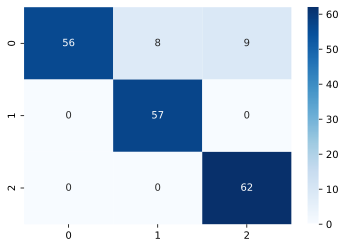

In [120]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_prd), annot=True, fmt='d', cmap='Blues')

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_prd))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        73
           1       0.88      1.00      0.93        57
           2       0.87      1.00      0.93        62

    accuracy                           0.91       192
   macro avg       0.92      0.92      0.91       192
weighted avg       0.92      0.91      0.91       192

